## 最終課題(irisデータのニューラルネットワーク構築)

In [4]:
# 必要なライブラリのインポート
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定

from common import functions
from common import optimizer
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# データセットのロード
# iris.data = [(がく片の長さ , がく片の幅 , 花びらの長さ , 花びらの幅)]
iris = datasets.load_iris()

x_vals = np.array([x[0:3] for x in iris.data])
y_vals = np.array([x[3] for x in iris.data])

# トレーニングデータ（80％）とテストデータ（20％）に分割
x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=0.2, shuffle=True)

In [5]:
class LayerNet:
    
    # コンストラクタ
    def __init__(self):
        self.input_size = 3
        self.hidden_size1 = 20
        self.hidden_size2 = 8
        self.output_size = 1
        self.batch_size = 30
        self.weight_init = 0.05
        self.learning_rate = 0.001
    
    # ネットワークの初期化を実施
    def init_network(self):
        network = {}
    
        # 重みの設定
        # 通常設定
        network['W1'] = self.weight_init * np.random.randn(self.input_size, self.hidden_size1)
        network['W2'] = self.weight_init * np.random.randn(self.hidden_size1, self.hidden_size2)
        network['W3'] = self.weight_init * np.random.randn(self.hidden_size2, self.output_size)

#         # Xavierでの設定
#         network['W1'] = np.random.randn(input_layer_size, hidden_layer_size1) / (np.sqrt(input_layer_size))
#         network['W2'] = np.random.randn(hidden_layer_size1, hidden_layer_size2) / (np.sqrt(hidden_layer_size1))
#         network['W3'] = np.random.randn(hidden_layer_size2, output_layer_size) / (np.sqrt(hidden_layer_size2))

        # Heでの設定
#         network['W1'] = np.random.randn(self.input_size, self.hidden_size1) / (np.sqrt(self.input_size)) * np.sqrt(2)
#         network['W2'] = np.random.randn(self.hidden_size1, self.hidden_size2) / (np.sqrt(self.hidden_size1)) * np.sqrt(2)
#         network['W3'] = np.random.randn(self.hidden_size2, self.output_size) / (np.sqrt(self.hidden_size2)) * np.sqrt(2)

        # バイアスの設定
        network['b1'] = np.zeros(self.hidden_size1)
        network['b2'] = np.zeros(self.hidden_size2)
        network['b3'] = np.zeros(self.output_size)

        return network
    
    def gradient(self, network, x_vec, y_vec):
        # ランダムにバッチを取得    
        batch_mask = np.random.choice(len(x_vec), self.batch_size)
        # ミニバッチに対応する教師訓練ラベルデータを取得    
        x_batch = x_vec[batch_mask]
        # ミニバッチに対応する訓練正解ラベルデータを取得する
        y_batch = y_vec[batch_mask]
        y_batch = y_batch[:, np.newaxis]

        z1, z2, y = self.forward(network, x_batch)
        grad = self.backward(x_batch, y_batch, z1, z2, y)

        # optimizerの設定 モメンタムを利用
        opt = optimizer.Momentum(self.learning_rate)
        opt.update(network, grad)
        
        return y_batch, y
    
    # 順伝播
    def forward(self, network, x):
        W1, W2, W3 = network['W1'], network['W2'], network['W3']
        b1, b2, b3 = network['b1'], network['b2'], network['b3']

        # 勾配
        u1 = np.dot(x, W1) + b1
        # 活性化関数 Relu関数を使用
        z1 = functions.relu(u1)
        # 勾配
        u2 = np.dot(z1, W2) + b2
        # 活性化関数 Relu関数を使用
        z2 = functions.relu(u2)
        # 勾配
        u3 = np.dot(z2, W3) + b3
        # 誤差関数(恒等写像)
        y = u3

        return z1, z2, y

    # 逆伝播
    def backward(self, x, d, z1, z2, y):
        grad = {}

        W1, W2, W3 = network['W1'], network['W2'], network['W3']
        b1, b2, b3 = network['b1'], network['b2'], network['b3']

        # 出力層でのデルタ 
        delta3 = functions.d_least_square(d, y)
        # b3の勾配
        grad['b3'] = np.sum(delta3, axis=0)
        # W3の勾配
        grad['W3'] = np.dot(z2.T, delta3)
        # 活性化関数の導関数 Relu関数
        delta2 = np.dot(delta3, W3.T) * functions.d_relu(z2)
        # b2の勾配
        grad['b2'] = np.sum(delta2, axis=0)
        # W2の勾配
        grad['W2'] = np.dot(z1.T, delta2)
        # 活性化関数の導関数 Relu関数
        delta1 = np.dot(delta2, W2.T) * functions.d_relu(z1)
        # b1の勾配
        grad['b1'] = np.sum(delta1, axis=0)
        # W1の勾配
        grad['W1'] = np.dot(x.T, delta1)

        return grad

Generation: 10. 誤差 = 16.069198383089123
Generation_Test: 10. 誤差(テスト) = 8.035057281347306
Generation: 20. 誤差 = 11.239299708788364
Generation_Test: 20. 誤差(テスト) = 8.230055781920937
Generation: 30. 誤差 = 6.371326926219105
Generation_Test: 30. 誤差(テスト) = 5.827385953561339
Generation: 40. 誤差 = 5.196689892100729
Generation_Test: 40. 誤差(テスト) = 6.346175598242868
Generation: 50. 誤差 = 3.922670588520267
Generation_Test: 50. 誤差(テスト) = 6.6151597444665065
Generation: 60. 誤差 = 4.028505415317504
Generation_Test: 60. 誤差(テスト) = 3.9859568073392384
Generation: 70. 誤差 = 2.2186769125351122
Generation_Test: 70. 誤差(テスト) = 3.483145040526656
Generation: 80. 誤差 = 2.3172119135058376
Generation_Test: 80. 誤差(テスト) = 1.634999986738525
Generation: 90. 誤差 = 1.2224307009589646
Generation_Test: 90. 誤差(テスト) = 1.472191129542951
Generation: 100. 誤差 = 1.5901219296803633
Generation_Test: 100. 誤差(テスト) = 0.8336208927393034
Generation: 110. 誤差 = 0.5797753768175595
Generation_Test: 110. 誤差(テスト) = 0.5055988430484026
Generation: 120. 

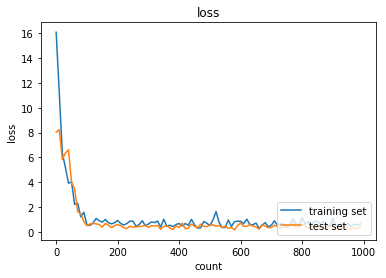

In [9]:
# 学習回数(1000回)
learning_num = 1000

# 描写頻度
plot_interval=10

layerNet = LayerNet()

# パラメータの初期化
network = layerNet.init_network()

losses = []
losses_test = []

for i in range(learning_num):
    # 訓練用の学習
    y_batch, y = layerNet.gradient(network, x_train, y_train)

    # テスト用の学習
    y_test_batch, y_t = layerNet.gradient(network, x_test, y_test)
    
    if (i + 1) % plot_interval == 0:
        loss = functions.least_square(y_batch, y)
        losses.append(loss)
        print('Generation: ' + str(i+1) + '. 誤差 = ' + str(loss))
        loss_test = functions.least_square(y_test_batch, y_t)
        losses_test.append(loss_test)
        print('Generation_Test: ' + str(i+1) + '. 誤差(テスト) = ' + str(loss_test))

lists = range(0, learning_num, plot_interval)
plt.plot(lists, losses, label="training set")
plt.plot(lists, losses_test, label="test set")
plt.legend(loc="lower right")
plt.title("loss")
plt.xlabel("count")
plt.ylabel("loss")
# グラフの表示
plt.show()